<a href="https://colab.research.google.com/github/WinetraubLab/roi-classification-foundation-model/blob/main/compute_uni_heatmap.ipynb" target="_blank">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>
  
<a href="https://github.com/WinetraubLab/roi-classification-foundation-model/blob/main/compute_uni_heatmap.ipynb" target="_blank">
  <img src="https://img.shields.io/badge/view%20in-GitHub-blue" alt="View in GitHub"/>
</a>

# Overview
This notebook will compute similarity heatmap between quarry patch and test image using [UNI](https://www.nature.com/articles/s41591-024-02857-3).


In [1]:
# @title Script Inputs

# Input images
test_image_file_path = "/content/drive/Shareddrives/Yolab - Current Projects/Kyi Lei Aye/UNI_Model/Figure S4/FigureS4_c.jpg"
query_patch_file_path = "/content/drive/Shareddrives/Yolab - Current Projects/Kyi Lei Aye/UNI_Model/Ref_images/6_i_resized.png"

In [2]:
# @title Environment Setup

if not 'setup_env' in globals():
  setup_env = True

  # Mount drive
  from google.colab import drive
  drive.mount('/content/drive')

  # Clone repository
  !git clone --recurse-submodules https://github.com/WinetraubLab/roi-classification-foundation-model/
  %cd ./roi-classification-foundation-model/

  # Install all requirements
  !pip install -r requirements.txt

# Imports
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from uni_score import UNIScore
from my_heatmap import get_patch_from_image
from tqdm import tqdm

# Boot up UNI
uni = UNIScore()

Mounted at /content/drive
Cloning into 'roi-classification-foundation-model'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 39 (delta 17), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (39/39), 481.91 KiB | 2.80 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/roi-classification-foundation-model
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 14.5 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's

/content/roi-classification-foundation-model/uni_score.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model.load_state_dict(torch.load(uni_weights_file_path, map_

Query Patch:


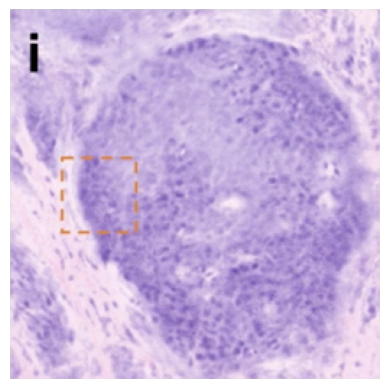

Test Patch (Healthy):


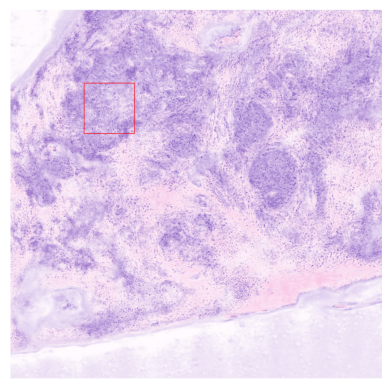

Healthy Score is 0.579
Test Patch (BCC):


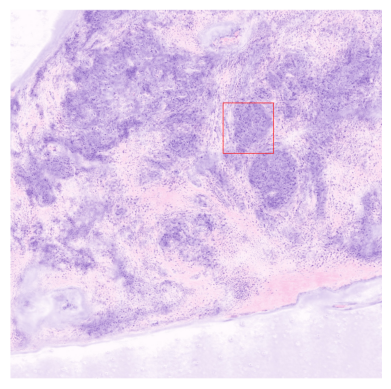

BCC Score is 0.610


In [9]:
# @title Compute One Patch Score

# Open the images
test_image = Image.open(test_image_file_path).convert("RGB")
query_patch = Image.open(query_patch_file_path).convert("RGB")

# Show query patch
print("Query Patch:")
plt.imshow(query_patch)
plt.axis('off')  # Hide axes for better visibility
plt.show()

# Show test patch and compute test score
print("Test Patch (Healthy):")
patch = get_patch_from_image(test_image, 500, 500, plot_patch_over_image = True);
score_healthy = uni.compute_similarity_between_patches(patch, query_patch)
print(f"Healthy Score is {score_healthy:.3f}")

print("Test Patch (BCC):")
patch = get_patch_from_image(test_image, 1200, 600, plot_patch_over_image = True);
score_bcc = uni.compute_similarity_between_patches(patch, query_patch)
print(f"BCC Score is {score_bcc:.3f}")


100%|██████████| 64/64 [01:48<00:00,  1.69s/it]


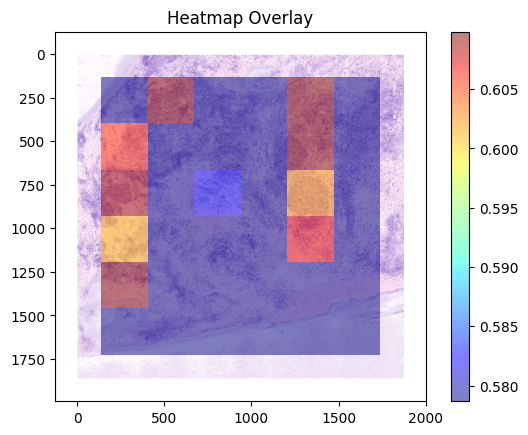

In [17]:
# @title Compute Heatmap

patch_size = 256
patch_half_size = patch_size // 2
heatmap_jump = patch_half_size

# Create a 2D array to store scores
width, height = test_image.size
score_array = np.zeros((1+(height // heatmap_jump), 1+(width // heatmap_jump))) * np.nan

# Loop through the image and compute score
query_emb = uni.compute_patch_embedding(query_patch,patch_size)
with tqdm(total=score_array.size) as pbar:
  for x_i in range(0, width, heatmap_jump):
    for y_i in range(0, height, heatmap_jump):
      try:
        patch = get_patch_from_image(test_image, x_i, y_i);
        patch_emb = uni.compute_patch_embedding(patch,patch_size)
        score = uni.compute_similarity_between_embeddings(patch_emb, query_emb)
      except ValueError: # Failed to capture a patch because it was outside of image boundary
        score = np.nan
      score_array[y_i // heatmap_jump, x_i // heatmap_jump] = score
      pbar.update(1)

# Plot the heatmap overlay on the image
fig, ax = plt.subplots()
ax.imshow(test_image)

# Create a heatmap
cax = ax.imshow(score_array, cmap='jet', alpha=0.5, extent=[-patch_half_size, width+patch_half_size, height+patch_half_size, -patch_half_size])

# Add color bar and limit according to healthy and desies tissue
plt.colorbar(cax, ax=ax)
cax.set_clim((score_healthy,score_bcc))

# Show the plot
plt.title('Heatmap Overlay')
plt.show()
